# Human-In-the-Loop, Interrupts and UI Integration
This notebook invetigates:
- Langgraph Interrupts
- Different HITL workflows
- Gradio integration with Langgraph

### Imports

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
# import HumanMessages for the LLM invocation
from langchain_core.messages import HumanMessage
# import checkpointer
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, END, START
from langgraph.types import interrupt, Command

from pydantic import BaseModel
from typing import Optional

import os
from dotenv import load_dotenv
load_dotenv()

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

 ### Gemini LLM Instance.

In [2]:
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)

E0000 00:00:1765812457.709332    5088 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


## Simple Interrupt Example - Approval Workflow
Simple example to demonstrate how to add an approval action into graph workflow. 

In [3]:
class SimpleState(BaseModel):
    action: Optional[str] = None
    approved: Optional[bool] = False

The approval node below contains an interrupt.  After the graph is invoked, it will return the information passed to the interrupt.

When the graph is resumed the values passed are returned from the interrupt function in the node.  The node can then continue to process the rest of the node.

Note that when the graph resumes it re-executes the whole node, so code before the interrupt will be executed again.

In [4]:
from langgraph.types import interrupt

# Node with interrupt
def approval_node(state: SimpleState):
    # Pause and ask for approval
    approved = interrupt("Do you approve this action?")

    # When you resume, Command(resume=...) returns that value here
    return {"approved": approved}

# Node before the interrupt
def proposed_action(state: SimpleState):
    # Propose an action
    return {"action": "Make a payment of $1000 to Vendor X."}

# Node to handle approved action
def approve_action(state: SimpleState):
    print("The proposed action was approved.")

# Node to handle not approved action
def not_approved(state: SimpleState):
    print("The proposed action was not approved.")

The graph is a router workflow, with a conditional edge depending on the state of the approval. 

In [5]:
# build the workflow
workflow = StateGraph(SimpleState)
# add nodes for the four functions above
workflow.add_node(proposed_action)
workflow.add_node(approval_node)
workflow.add_node(approve_action)
workflow.add_node(not_approved)

# create edges
workflow.add_edge(START, "proposed_action")
workflow.add_edge("proposed_action", "approval_node")
workflow.add_conditional_edges("approval_node", 
                               lambda s: s.approved==True, 
                               path_map={True: "approve_action", False: "not_approved"})
workflow.add_edge("approve_action", END)
workflow.add_edge("not_approved", END)

# create checkpointer
saver = InMemorySaver()
approval_graph = workflow.compile(checkpointer=saver)

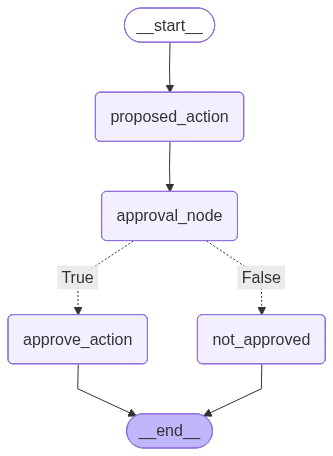

In [6]:
approval_graph

The first invocation of the graph returns and interrupt.

In [7]:
# create config
config : RunnableConfig = {"configurable":{"thread_id":"Thread_1"}}

# invoke the workflow with an interrupt
approval_interrupt = approval_graph.invoke(SimpleState(), config=config)

The interrupt information is found against the key __interrupt__

In [8]:
approval_interrupt['__interrupt__']

[Interrupt(value='Do you approve this action?', id='cb8ec221830ae61ffc62beb5eebdd329')]

The graph is resumed with the Command object, passing the return values against the resume property

In [9]:
# resume the workflow with approved/not approved.  Must pass the same config with thread_id
approval_graph.invoke(Command(resume=True), config=config)

The proposed action was approved.


{'action': 'Make a payment of $1000 to Vendor X.', 'approved': True}

## Simple Interrupt Example - Review and Edit 

This providees a similar example to the approval example, except demonstrates a common HITL pattern of reviewing and editing an output of an LLM.  This allows additional information to be passed from the interrupt

In [10]:


from typing import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt


class ReviewState(TypedDict):
    generated_text: str
    recipient: Optional[str]

def review_node(state: ReviewState):
    # Ask a reviewer to edit the generated content
    updated = interrupt({
        "instruction": "Review and edit this content",
        "content": state["generated_text"],
    })
    return {"generated_text": updated["content"], "recipient": updated.get("recipient")}


builder = StateGraph(ReviewState)
builder.add_node("review", review_node)
builder.add_edge(START, "review")
builder.add_edge("review", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)


In [11]:
config : RunnableConfig = {"configurable": {"thread_id": "review-42"}}
initial = graph.invoke(ReviewState(generated_text="Initial draft", recipient="unknown"), config=config)
print("========== Initial Interrupt ==========")
print(initial["__interrupt__"])  # -> [Interrupt(value={'instruction': ..., 'content': ...})]


========== Initial Interrupt ==========
[Interrupt(value={'instruction': 'Review and edit this content', 'content': 'Initial draft'}, id='d6066c21c61ca4bb91d436231e0308e1')]


In [12]:

# Resume with the edited text from the reviewer
final_state = graph.invoke(
    Command(resume={"content": "Improved draft after review", "recipient": "bob"}),
    config=config,
)
print("========== Final State ==========")
print(final_state)  # -> "Improved draft after review"

========== Final State ==========
{'generated_text': 'Improved draft after review', 'recipient': 'bob'}


## Interrupts in Tools
Interrupts can also be placed inside tool nodes.  This allows for approval, validating or editing before a tool returns its results back to the graph.  This can act as an effective **guardrail** for high risk tool actions.

Tools are provided to send the mail (with authorisation) and another tool to allow the LLM to request more information from the user.

In [13]:
from langchain.tools import tool
from langgraph.types import interrupt

@tool
def send_email(to: str, subject: str, body: str):
    """Send an email to a recipient."""

    # Pause before sending; payload surfaces in result["__interrupt__"]
    response = interrupt({
        "action": "send_email",
        "to": to,
        "subject": subject,
        "body": body,
        "prompt": "Approve sending this email?"
    })

    if response == "approve":

        return f"Email sent to {to} with subject '{subject}'"
    return "Email cancelled by user"

@tool
def get_user_input(prompt: str) -> str:
    """Get input from the user based on a prompt requesting information you need to complete a task."""
    response = interrupt({
        "action": "get_user_input",
        "prompt": prompt,
        "message": "Please provide your input."
    })
    return response

Create the graph, which is a standard ReAct implementation

In [14]:
# import toolNode
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
# create graph as simple react with send_email tool.  Start with node to write email, then send_email tool
graph = StateGraph(MessagesState)
graph.add_node("create_email", lambda state: {"messages": llm.bind_tools([send_email, get_user_input]).invoke(state['messages'])})
graph.add_node("tool_node", ToolNode([send_email, get_user_input]))

graph.add_edge(START, "create_email")
graph.add_conditional_edges("create_email", lambda state: state['messages'][-1].tool_calls != [],
                           path_map={True: "tool_node", False: END})
graph.add_edge("tool_node", "create_email")

checkpointer = MemorySaver()
email_graph = graph.compile(checkpointer=checkpointer)




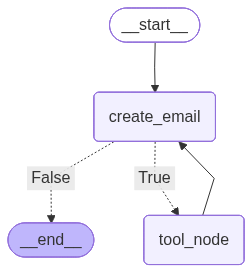

In [15]:
email_graph

In [16]:
messages = [HumanMessage(content="Write an email to Alice about our meeting next week.")]
config : RunnableConfig = {"configurable": {"thread_id": "email-123"}}
result = email_graph.invoke({"messages": messages}, config=config)
while "__interrupt__" in result:
    interrupt_info = result["__interrupt__"]
    print("Interrupt:", interrupt_info)
    response = input(interrupt_info[0].value['prompt'])
    result = email_graph.invoke(Command(resume=response), config=config)

print(" ============ Final Result ============")
result['messages'][-1].content

 ============ Final Result ============


'I can help with that! What day and time is the meeting, and what should I include in the email?'

# Example - Write, Review and Edit Email

In [17]:


# ----------- STATE MODEL -----------
class State(BaseModel):
    topic: str
    draft: Optional[str] = None
    approved: Optional[bool] = False
    changes: Optional[str] = None
    final: Optional[str] = None

# ----------- NODES -----------
def generate_draft(state: State):
    # Replace with your LLM of choice
    response = llm.invoke([HumanMessage(content=f"Write a short email about {state.topic}.")])
    return {"draft": response.content}
   # return {"draft": "Dear Customer,\n\nWishing you a joyous holiday season and a prosperous New Year!\n\nBest regards,\nYour Company"  }

def review_interrupt(state: State):
    # Pause workflow and ask human to approve draft
    
    response = interrupt(value={"draft": state.draft,
        "message": "Please approve or revise the draft."})
    
    if response == "approved":
        return {"approved": True, "final": state.draft}
    else:
        return {"approved": False, "changes": response}


def make_changes(state: State):
    # Replace with your LLM of choice
    response = llm.invoke([HumanMessage(content=f"""The user has requested the following changes to the draft: <CHANGES>{state.changes}</CHANGES>.
                                        \n\n Please revise the draft accordingly:\n\n<DRAFT>{state.draft}</DRAFT>""")])
    return {"draft": response.content}
    

def finalise(state: State):
    if state.approved:
        return {"final": f"Email ready to send:\n\n{state.draft}"}
    else:
        return {"final": f"Revised draft accepted:\n\n{state.draft}"}

# ----------- GRAPH BUILD -----------
graph = StateGraph(State)

graph.add_node("generate_draft", generate_draft)
graph.add_node("review_interrupt", review_interrupt)
graph.add_node("make_changes", make_changes)
graph.add_node("finalise", finalise)

graph.add_edge("generate_draft", "review_interrupt")
graph.add_conditional_edges("review_interrupt", 
    path=lambda state: state.approved, 
    path_map={
    True: "finalise",
    False: "make_changes"
})
graph.add_edge("make_changes", "review_interrupt")
graph.set_entry_point("generate_draft")

# create checkpointer
saver = InMemorySaver()
workflow = graph.compile(checkpointer=saver)


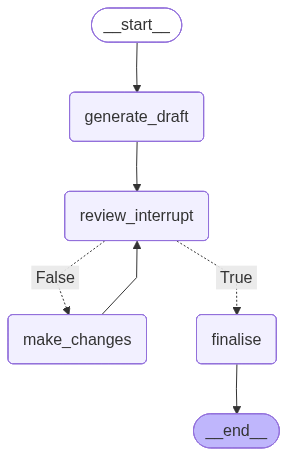

In [18]:
workflow

In [19]:
config: RunnableConfig = {"configurable": {"thread_id": "1"}}

result = workflow.invoke(State(topic="Produce a short Christmas email to a customer"), config=config)

In [20]:
result['__interrupt__'][0].value['draft']

"Subject: Wishing You a Merry Christmas from [Your Company Name]!\n\nDear [Customer Name],\n\nAs the festive season approaches, we wanted to take a moment to wish you and yours a very Merry Christmas!\n\nWe're so grateful for your continued support throughout the year. We hope you have a wonderful time filled with joy, laughter, and delicious treats.\n\nWishing you all the best for a happy and healthy New Year!\n\nWarmly,\n\nThe Team at [Your Company Name]"

In [21]:
for step in workflow.get_state_history(config):
    print(step)

StateSnapshot(values={'topic': 'Produce a short Christmas email to a customer', 'draft': "Subject: Wishing You a Merry Christmas from [Your Company Name]!\n\nDear [Customer Name],\n\nAs the festive season approaches, we wanted to take a moment to wish you and yours a very Merry Christmas!\n\nWe're so grateful for your continued support throughout the year. We hope you have a wonderful time filled with joy, laughter, and delicious treats.\n\nWishing you all the best for a happy and healthy New Year!\n\nWarmly,\n\nThe Team at [Your Company Name]", 'approved': False}, next=('review_interrupt',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d9cb0-86dd-6c88-8001-486a825b7901'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-15T15:30:49.149131+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d9cb0-79e2-603b-8000-25c14aa3db21'}}, tasks=(PregelTask(id='51c99a4c-b896-ea2d-4011

In [22]:
workflow.invoke(Command(resume="Please address the email to Bob"), config=config)

{'topic': 'Produce a short Christmas email to a customer',
 'draft': "Subject: Wishing You a Merry Christmas from [Your Company Name]!\n\nDear Bob,\n\nAs the festive season approaches, we wanted to take a moment to wish you and yours a very Merry Christmas!\n\nWe're so grateful for your continued support throughout the year. We hope you have a wonderful time filled with joy, laughter, and delicious treats.\n\nWishing you all the best for a happy and healthy New Year!\n\nWarmly,\n\nThe Team at [Your Company Name]",
 'approved': False,
 'changes': 'Please address the email to Bob',
 '__interrupt__': [Interrupt(value={'draft': "Subject: Wishing You a Merry Christmas from [Your Company Name]!\n\nDear Bob,\n\nAs the festive season approaches, we wanted to take a moment to wish you and yours a very Merry Christmas!\n\nWe're so grateful for your continued support throughout the year. We hope you have a wonderful time filled with joy, laughter, and delicious treats.\n\nWishing you all the best

# Gradio
You will need to install gradio: uv add gradio

The code below demonstrates a simple user interface for the graph above.


In [23]:

# Very Simple Gradio App

import gradio as gr

# input and output parameters must match the number of inputs and outputs in the event binding
def welcome_message(name: str) -> str:
    return f"Welcome, {name}!"

with gr.Blocks() as demo:
    # declare components
    name_box = gr.Textbox(label="Enter you name")
    welcome_btn = gr.Button("Generate a welcome message")
    welcome_output = gr.Textbox(label="Welcome Message", lines=2)
    
    # bind function to button click
    welcome_btn.click(fn=welcome_message, inputs=name_box, outputs=welcome_output)
    
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [27]:
import gradio as gr

# Function to interact with the workflow graph
def call_generate_draft(topic: str):
    prompt = f"Produce a short email for the following topic: {topic}" 
    return workflow.invoke(State(topic=topic), config=config)['draft']

def update_draft(changes: str):
    return workflow.invoke(Command(resume=changes), config=config)['draft'], ""

# Create the UI Components that Gradio will Render
with gr.Blocks() as demo:
    # Declare Gradio Components
    input_box = gr.Textbox(label="Create an Email for the following topic:")
    start_btn = gr.Button("Generate Draft Email")
    draft_box = gr.Textbox(label="Draft", lines=5)
    revision_box = gr.Textbox(label="Request Changes")
    approval = gr.Button("Approve")
    final_output = gr.Textbox(label="Final Result", lines=5)


    # Binding Functions to Gradio Components Actions
    # For each action you can specify the input and output components
    start_btn.click(fn=call_generate_draft, inputs=input_box, outputs=draft_box)
    approval.click(fn=lambda: workflow.invoke(Command(resume="approved"), config=config)['final'], outputs=final_output)
    revision_box.submit(fn=update_draft, inputs=revision_box, outputs=[draft_box, revision_box])

# Run the Gradio App
demo.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
